In [1]:
import numpy as np

from commonmethods.data_init import read_data, get_bin_files_in_dir, save_matrices_in_ascii, get_window
from commonmethods.fitter import AmplitudeFitter
from commonmethods.filtration import Filtrator

In [2]:
files = get_bin_files_in_dir(
    #'C:\\Users\\ru\\Documents\\производственная практика\\иен\\PrBFO_125__5_400_430_20_15___Place 1\\fourier_amp_ph'
    "C:\\Users\\ru\\Documents\\производственная практика\\иен\\cbzt_11_DFL 2\\cbzt_11_DFL\\cbzt_11_DFL_fourier_amp_ph"
)

fitter = AmplitudeFitter(
    #'C:\\Users\\ru\\Documents\\производственная практика\\иен\\PrBFO_125__5_400_430_20_15___Place 1\\paramiters.txt'
    "C:\\Users\\ru\\Documents\\производственная практика\\иен\\cbzt_11_DFL 2\\cbzt_11_DFL\\cbzt_11_DFL_paramiters.txt"
)

filtrator = Filtrator(0, fitter.params['bins_number'])

[ 0.06266064  0.00019644  0.11153234]


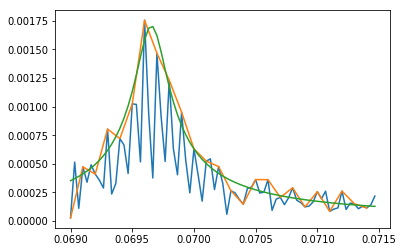

In [3]:
data = read_data(files[999])

filtered_freq, filtered_amp = filtrator.filter_signal(data['freq'], data['amp'])
est, cov = fitter.fit(filtered_freq, filtered_amp)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data['freq'], data['amp'])
plt.plot(filtered_freq, filtered_amp)
plt.plot(data['freq'], fitter.model_func(data['freq'], *est))
print(np.sqrt(np.diag(cov)) / est) #вроде это относительная ошибка параметров, если больше какого-то порога, надо маскировать

In [ ]:
fits = []
covs = []
r_squared_measures = []
for i in range(len(files)):
#for file in files:
    file = files[i]
    data = read_data(file)
    filtered_freq, filtered_amp = filtrator.filter_signal(data['freq'], data['amp'])
    try:
        est, cov = fitter.fit(filtered_freq, filtered_amp)
        
        covs.append(cov)
        
        amp_val = est[0]
        amp_ind = (np.abs(filtered_amp-amp_val)).argmin()
        window = get_window(amp_ind, 10, 0, len(filtered_amp))
        phase_around_peak = filtrator.filter_array(data['phase'])[range(window[0], window[1])]
        
        '''r squared goodness of fit'''
        ss_res = np.sum((filtered_amp - fitter.model_func(filtered_freq, *est)) ** 2)
        ss_tot = np.sum((filtered_amp - np.mean(filtered_amp)) ** 2)
        r_sq = 1 - (ss_res / ss_tot)
        r_squared_measures.append(r_sq)
        
        phase_val = phase_around_peak.mean()
        est = np.append(est, phase_val)
    except RuntimeError:
        print(file)
        est = None
    fits.append(est)

In [ ]:
import time
import multiprocessing
start = time.time()

def temp_(file):
    with open(r'C:\____.txt', 'w') as f: f.write('kek')
    data = read_data(file)
    print('kek')
    return fitter.fit(filtrator.filter_signal(data['freq'], data['amp']))[0]

with multiprocessing.Pool(2) as p:
    multiprocessing.freeze_support()
    fits = p.map(temp_, files[:1])
end = time.time()
print(start - end)

In [ ]:
np_fits = np.array(fits)
#failed_points = [i for i in range(len(r_squared_measures)) if r_squared_measures[i] < 0.50]
failed_points = []
print(len(failed_points))
succesful_fits = np.ma.array(np_fits)
succesful_fits[failed_points] = np.ma.masked
mins = [np.min(succesful_fits[:,i]) for i in range(len(succesful_fits[0]))]

data_arrays = [np.array([val if val is not (np.ma.masked or None) else mins[i]
                         for val in succesful_fits[:,i]])
               for i in range(len(succesful_fits[0]))]

data_matrices = [np.reshape(data_array, (fitter.params['number_of_lines'], fitter.params['number_of_points_in_line']))
                 for data_array in data_arrays]

names = 'amp freq qual phase'.split()
fit_matrices = {names[i]: data_matrices[i] for i in range(len(data_matrices))}

In [ ]:
save_matrices_in_ascii(fit_matrices, 'C:\\Users\\ru\\Documents\\git\\spm_data_analysis\\testingparallel')